<p style="text-align: center;" ><font size="+3"><u><b>Laboratory 4: Optimization Example</u></b></p>

<div class="alert alert-block alert-warning">
<font color=black>
This notebook provides an example optimization problem. In engineering applications, we frequently assume a model for our acquired data, and find the best model parameters that fit the data. In this example, we assume a simple paraboloidal model and generate the data using simulation. In the lab, you will be fitting the Fourier optics model we learned in class to data acquired from the microscope. <br/><br/>

We will be using an optimization algorithm called Covariance matrix adaptation evolution strategy (CMA-ES). The algorithm is implemented in the Python package `cma`, which we already installed on all the lab computers. You can install the package on your own computers by running `conda install -c conda-forge cma --yes` in the Python terminal.  </font> </div>

In [1]:
# import python packages
import cma
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
plt.rcParams['font.size'] = 16   # set the font size globally

<div class="alert alert-block alert-warning">
<font color=black>

Let's first simulate data we want to fit to. Suppose the data follow an elliptic paraboloid given by:
\begin{equation}
\frac{(U-o_1)^2}{a^2} + \frac{(V-o_2)^2}{b^2}
\end{equation} 
where $(U,V)$ are the two dimensional coordinates, $(o_1, o_2)$ defines the center of the paraboloid, and $(a, b)$ are the radii of the ellipse.  

The model is implemented in the `elliptic_paraboloid` function below. We then simulate the data that we might measure from a system, labelled `target_surf`, using a set of predefined $(o_1, o_2, a, b)$. We also add noise to the data to emulate noisy data we get from empirical experiments. 

</font> 
</div>

In [2]:
def elliptic_paraboloid(U, V, o1, o2, a, b):
    return (U - o1)**2 / a**2 + (V - o2)**2 / b**2

In [3]:
# make a target surface to fit to

# define parameters
o1, o2, a, b = 56, -250, 2.9, 2.5
u = v = np.arange(-100, 101) * 10.
v = np.arange(-100, 101) * 10.
[U, V] = np.meshgrid(u, v)

# construct an elliptic paraboloid
target_surf = elliptic_paraboloid(U, V, o1, o2, a, b)
# add random noise to the data
target_surf = target_surf + np.random.randn(target_surf.shape[0], target_surf.shape[0])*1e4

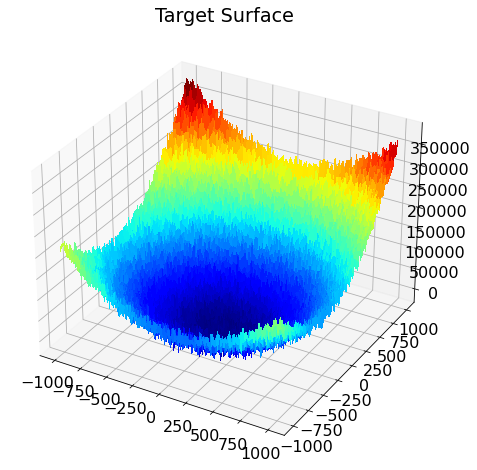

In [4]:
# display the target surface
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={"projection": "3d"})
surf = ax.plot_surface(U, V, target_surf, cmap='jet', linewidth=0, antialiased=False)
ax.set_title('Target Surface')
plt.show()

<div class="alert alert-block alert-warning">
<font color=black>

Now, suppose we only know that our data follow the elliptic paraboloid model but don't know the exact values of the parameters $(o_1, o_2, a, b)$. This is analogous to an example where we know our microscope has a circular aperture, but we don't know the radius of the aperture. Now we can use an optimization algorithm to find these unknown parameters. 
    
We first need to define an <b>objective function</b>, which should measure how close our modeled data are to the measured data. A simple way to quantify this is the sum of squared difference between the two. When this objective function reachs a minimum value (with differences due to noise only), we have found the parameters that best fit the measured data.  
    
We have provided an objective function, `objfunc_paraboloid`, below. The input arguments are `xv` ( $xv=[o_1, o_2, a, b]$), the target surface `target_surf`, and the coordinates `U`, `V`. The function has the following syntax:<br/>

`sqe = objfunc_paraboloid(xv, target_surf, U, V)` <br/>
    
The function first parse the vector into parameters of our model, $o_1$, $o_2$, $a$, and $b$. Then, it uses the given values to obtain an estimated surface. Then, we compute the sum of squared error between the two surfaces. 

</font> 
</div>

In [5]:
def objfunc_paraboloid(xv, target_surf, U, V):
    # parse optimization parameters
    o1, o2, a, b = xv[0], xv[1], xv[2], xv[3]
    # model prediction of paraboloid  
    est_surf = elliptic_paraboloid(U, V, o1, o2, a, b)
    # calculate the objective function - sum of squared error
    sqe = np.sum((target_surf - est_surf)**2)
    return sqe

<div class="alert alert-block alert-warning">
<font color=black>
We can then use the CMA-ES algorithm to identify the optimal parameters $o_1$, $o_2$, $a$, and $b$. The optimization routine is accomplished by the following code. The algorithm first evaluates an estimated surface using the initial guesses, and then updates the parameters in iterations, each time getting closer 
to the optimum. An example call to CMA-ES is given below:
</font> 
</div>

In [6]:
# first provide initial guesses to o1, o2, a, and b in the variable x0
# x0 is a vector of the initial guesses for xv and should be 
# the same size as your optimization parameter vector
x0 = [54, -100, 2.5, 2.5] 

# then set parameters for CMA-ES
# these parameters can affect the convergence speed and termination criteria of the optimization
# Leave them, as is, for now.
tolfun = 5e11
tolx = 1e-2  
sigma0 = 0.1
popsize = 20  # population size

# create a dictionary containing all parameters
opts = {'tolfun':tolfun, 'tolx':tolx, 'popsize':popsize}

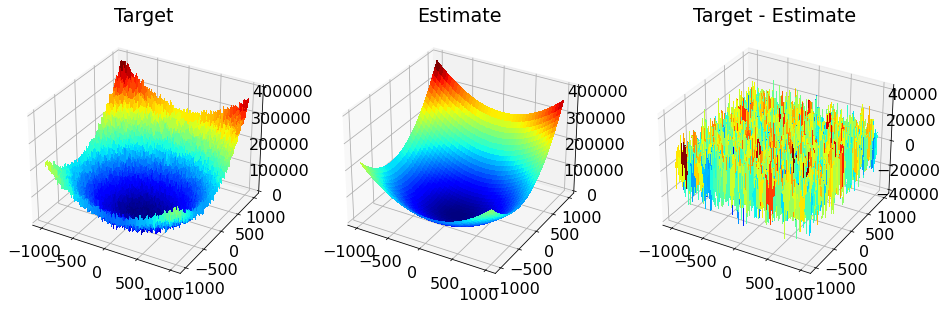

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   57   1140 4.024859434160943e+12 6.5e+02 1.51e+00  1e-03  5e-01 0:01.6
Target Parameters:  [56, -250, 2.9, 2.5]
Estimated Parameters (Solution):  [  55.9 -249.7    2.9    2.5]
Final objective function value:  4024696056942.7344
Stopping criterion:  {'tolfun': 500000000000.0}


In [7]:
es = cma.CMAEvolutionStrategy(x0, sigma0, opts)  # initalize optimization
fit = np.empty(popsize)  # allocate memory for each population

show_surface_plot = True

if show_surface_plot is True:
    fig, ax = plt.subplots(ncols=3, figsize=(16,8), subplot_kw={"projection": "3d"})
    plt.close(fig)

while not es.stop():
    new_soln = es.ask()  # get a new solution
    for ct, soln in enumerate(new_soln):
        fit[ct] = objfunc_paraboloid(soln, target_surf, U, V)  # compute objective function
    es.tell(new_soln, fit)  # feed back the objective function values to cmaes
    
    if show_surface_plot:
        # display target surface
        ax[0].plot_surface(U, V, target_surf, cmap='jet', linewidth=0, antialiased=False)
        ax[0].set_title('Target')
        ax[0].set_zlim([0, 4e5])

        # display estimated surface
        estimated_surf = elliptic_paraboloid(U, V, *new_soln[np.argmin(fit)])
        ax[1].plot_surface(U, V, estimated_surf, cmap='jet', linewidth=0, antialiased=False)
        ax[1].set_title('Estimate')
        ax[1].set_zlim([0, 4e5])

        # display surface difference
        ax[2].plot_surface(U, V, target_surf-estimated_surf, cmap='jet', linewidth=0, antialiased=False)
        ax[2].set_title('Target - Estimate')
        

        clear_output(wait=True)
        display(fig)
        for i in range(len(ax)):
            ax[i].clear()
        es.disp_annotation()
        es.disp(1)  # display every iteration

    else:
        es.disp(5)  # display every 5 iterations


# es.result[0] returns the optimal parameters that minimize the objective function
# If the optimization is successful, xopt should be close to the values the script 
# used to generate the initial target surface.
xopt = es.result[0] 

# es.result[0] returns the value of the objective function using the optimal parameters
objfuncopt = es.result[1]

print('Target Parameters: ', [o1, o2, a, b])
print('Estimated Parameters (Solution): ', np.round(xopt,1))
print('Final objective function value: ', objfuncopt)
print('Stopping criterion: ', es.stop())